In [ ]:
#data_analysis env
# import pygam
# from pygam import LinearGAM, s, f
import xarray as xr
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import shap
from shapely.geometry import mapping
import geopandas as gpd

#segoeui font
plt.rcParams['font.family'] = 'Segoe UI'

#### Inputs

In [ ]:
src_meteo = r"D:\VUB\_data\_isimip_3b\model_outputs\meteo"
src_recharge = r"D:\VUB\_data\_isimip_3b\model_outputs\mHM_Gr_Fluxes_L2"
models = ['GFDL-ESM4', 'IPSL-CM6A-LR', 'MPI-ESM1-2-HR', 'UKESM1-0-LL']
meteo_vars = ['pre', 'pet']
scenarios = ['historical', 'ssp585']
#Boundaries data
be_shp = gpd.read_file(r"W:/VUB/_main_research/mHM/mhm_belgium/be_shp/be.shp")

In [ ]:
#clip to region
from shapely.geometry import mapping
def clip_to_region(shapefile, xr_dataset):
    """
    This function clips an xarray dataset to a given shapefile.

    Parameters
    ----------
    shapefile : geopandas.GeoDataFrame
        The shapefile to clip the dataset to.
    xr_dataset : xarray.Dataset
        The dataset to clip.

    Returns
    -------
    xarray.Dataset
        The clipped dataset.
    """
        #set shapefile to crs 4326
    shapefile = shapefile.to_crs('epsg:4326')

    #drop bnds dimension
    xr_dataset = xr_dataset.drop_dims("bnds", errors="ignore")

    #set spatial dimensions
    xr_dataset.rio.set_spatial_dims(x_dim="lon", y_dim="lat", inplace=True)

    #write crs
    xr_dataset.rio.write_crs('epsg:4326', inplace=True)

    #clip
    clipped = xr_dataset.rio.clip(shapefile.geometry.apply(mapping), shapefile.crs, drop=True)

    return clipped



def da_to_dict(src, models, scenarios, variables):
    data_dict = {}
    for model in models:
        for scenario in scenarios:
            for variable in variables:
                file_path = f"{src}/{model}/{scenario}/{variable}.nc"
                ds = xr.open_dataset(file_path)
                ds = clip_to_region(be_shp, ds)
                if variable == 'recharge_L2':
                    da = ds[['recharge']]
                else:
                    da = ds[[variable]]
                key = f"{model}_{scenario}_{variable}"
                data_dict[key] = da
    return data_dict

In [ ]:
#stack models on keys
def stack_models(meteo_dict, model_keys):
    stacked_models_meteo = []

    for key in model_keys:
        model_da = meteo_dict[key].assign_coords(model=key.split("_")[0])
        model_da = model_da.expand_dims("model")
        stacked_models_meteo.append(model_da)

    da = xr.concat(stacked_models_meteo, dim="model")
    return da

In [115]:
def compute_mon_deltas(hydro_dict, var, hist_slice, fut_slice, agg='sum'):
    """
    Return future monthly anomalies (future minus historical monthly climatology).
    Assumes daily data; set agg='mean' if inputs are daily means you want monthly means.
    """
    da_hist = hydro_dict[f'historical_{var}'].sel(time=hist_slice)
    da_fut  = hydro_dict[f'ssp585_{var}'].sel(time=fut_slice)

    # monthly aggregates
    hist_mon = getattr(da_hist.resample(time='ME'), agg)()
    fut_mon  = getattr(da_fut .resample(time='ME'), agg)()

    # historical monthly climatology (1..12)
    hist_mon_clim = hist_mon.groupby('time.month').mean('time')

    # anomalies for each future month (retain future time axis)
    fut_mon_anom = fut_mon.groupby('time.month') - hist_mon_clim

    # optional rename for recharge
    if var == 'mHM_Gr_Fluxes':
        fut_mon_anom = fut_mon_anom.rename({'recharge_L2': 'recharge'})
    #mask zero variance locations
    variance = fut_mon_anom.var(dim='time')
    fut_mon_anom = fut_mon_anom.where(variance != 0)

    return fut_mon_anom  # dims: time (monthly in future window), y, x


In [ ]:
def ens_stats(models_dict, scenarios, vars_list):
    stats_dict = {}
    for scenario in scenarios:
        for variable in vars_list:
            stacked_models = stack_models(models_dict, [key for key in models_dict.keys() if scenario in key and variable in key])

            #compute ensemble mean
            ens_mean = stacked_models.mean(dim='model')
            stats_dict[f"{scenario}_{variable}"] = ens_mean
    return stats_dict

#### Compute ensemble statistics

In [ ]:
#Group data into dictionaries
meteo_dict = da_to_dict(src_meteo, models, scenarios, meteo_vars)
recharge_dict = da_to_dict(src_recharge, models, scenarios, ['recharge_L2'])

#Compute ensemble means
ens_meteo_mean = ens_stats(meteo_dict, scenarios, meteo_vars)
ens_recharge_mean = ens_stats(recharge_dict, scenarios, ['recharge_L2'])
#replace recharge_L2 key with recharge
ens_recharge_mean = {key.replace('recharge_L2', 'recharge'): value for key, value in ens_recharge_mean.items()}

In [ ]:
#calculate water availability (p-pet) per scenario
water_availability = {}
for scenario in scenarios:
    pre = ens_meteo_mean[f"{scenario}_pre"]
    pet = ens_meteo_mean[f"{scenario}_pet"]
    wa = pre['pre'] - pet['pet']
    #wa to dataset
    wa = wa.to_dataset(name='wa')
    water_availability[f"{scenario}_wa"] = wa

#### Compute future changes

In [287]:
#resample to monthly and calculate changes
hist_time_slice = slice('1981-01-01', '2010-12-31')
fut_time_slice = slice('2071-01-01', '2100-12-31')

pre_delta = compute_mon_deltas(ens_meteo_mean, 'pre', hist_time_slice, fut_time_slice)
pet_delta = compute_mon_deltas(ens_meteo_mean, 'pet', hist_time_slice, fut_time_slice)
wa_delta = compute_mon_deltas(water_availability, 'wa', hist_time_slice, fut_time_slice)
recharge_delta = compute_mon_deltas(ens_recharge_mean, 'recharge', hist_time_slice, fut_time_slice)

da_merged = xr.merge([recharge_delta, pre_delta, pet_delta, wa_delta])

#### Extract timeseries of features

Extract timeseries for different soil regions: Campine (Sand), Loess (Loam), Ardennes (Sandy Loam)

In [288]:
#Soil regions of interest
region_names = ['Ardennen','Campine', 'Loess Region',
                'Campine_L', 'Ardennen_L', 'Loess_L']

#create df of regions and their coordinates (these are subsets of the regions not the entire regions)
roi_df = pd.DataFrame(index=region_names, columns=['min_lon','min_lat','max_lon','max_lat'])
roi_df.loc['Ardennen'] = [5.20, 49.90, 5.7, 50.4]
roi_df.loc['Campine'] = [4.45,50.90, 5.50, 51.40]
roi_df.loc['Loess Region'] = [4.6, 50.5, 5.2, 50.9]
roi_df.loc['Campine_L'] = [4.47,51.04,5.67, 51.45]
roi_df.loc['Ardennen_L'] = [5.127, 49.90, 6.14, 50.515]
roi_df.loc['Loess_L'] = [3.466, 50.479, 4.196, 50.907]

# dx = 0.0625
# dy = 0.0625

#for each roi, extract several timeseries based on dx, dy. average over pixels within dx, dy
roi_df.reset_index(inplace=True)
roi_df.rename(columns={'index':'name'}, inplace=True)

In [119]:
#for each roi, extract several timeseries based on dx, dy. average over pixels within dx, dy and store each in a dict
bbox_dict = {}
for index, row in roi_df.iterrows():
    name = row['name']
    min_lon = row['min_lon']
    min_lat = row['min_lat']
    max_lon = row['max_lon']
    max_lat = row['max_lat']

    #lon/lat ranges with dx, dy
    lat_range = np.arange(min_lat, max_lat+dy, dy)
    lon_range = np.arange(min_lon, max_lon+dx, dx)
    bbox_dict[name] = {'lat': lat_range, 'lon': lon_range}

In [518]:
def extract_roi_timeseries(da, region_name='entire_domain'):
    """
    Extract seasonal time series from one or all regions.

    Parameters
    ----------
    da : xr.DataArray
        DataArray with dimensions including 'time', 'lat', 'lon'.
    bbox_dict : dict
        Dict of {region_name: {'lat': lat_array, 'lon': lon_array}}.
    region_name : str, optional
        'all' for all regions, or a specific region key in bbox_dict.

    Returns
    -------
    pd.DataFrame
        Long DataFrame with seasonal time series stacked for tiles/regions.
    """
    da_df_list = []

    # Decide which regions to loop over
    if region_name == ['entire_domain']:
        #use the entire dataarray
        da_roi = da
        nlat, nlon = len(da_roi.lat), len(da_roi.lon)

        #extract timeseries for each grid cell in the region
        for i in range(nlat):
            for j in range(nlon):

                #extract timeseries
                ds_ = da_roi.isel(lat=i, lon=j).to_dataframe()[['pet', 'pre', 'wa', 'recharge']]

                if ds_.isnull().all().all():
                    continue

                # Seasonal aggregation (QS-DEC)
                da_df = ds_.resample('QS-DEC').sum()

                # Add region infif useful
                da_df['roi'] = 'entire_domain'

                da_df_list.append(da_df)

    elif isinstance(region_name, list) and set(region_name).issubset(set(roi_df['name'].values)):
        for name in region_name:
            bbox = roi_df[roi_df['name'] == name]
            da_roi = da.sel(lat=slice(bbox['max_lat'].max(), bbox['min_lat'].min()),
                            lon=slice(bbox['min_lon'].min(), bbox['max_lon'].max()))
            
            nlat, nlon = len(da_roi.lat), len(da_roi.lon)

            #extract timeseries for each grid cell in the region
            for i in range(nlat):
                for j in range(nlon):

                    #extract timeseries
                    ds_ = da_roi.isel(lat=i, lon=j).to_dataframe()[['pet', 'pre', 'wa', 'recharge']]

                    if ds_.isnull().all().all():
                        continue

                    # Seasonal aggregation (QS-DEC)
                    da_df = ds_.resample('QS-DEC').sum()

                    # Add region infif useful
                    da_df['roi'] = name

                    da_df_list.append(da_df)
    else:
        raise ValueError(f"region_name '{region_name}' not in roi_df['name'].values and not 'entire_domain'.")

    return da_df_list

In [519]:
#extract timeseries for defined regions

region_name = ['entire_domain']  #or specify a region from roi_df['name'].values
df_list_region = extract_roi_timeseries(da_merged, region_name = region_name)

#separate the dataframe into seasonal data
seasons = {
    'summer': [6],
    'autumn': [9],
    'winter': [12],
    'spring': [3]
    }

df_list_seasons = []

#add season column based on month
for df_region in df_list_region:
    df_region['season'] = df_region.index.month.map(lambda x: next((season for season, months in seasons.items() if x in months), None))

#     #QS-DEC generates 1 more extra winter season
# for df_region in df_list_region:
    df_region = df_region[(df_region.index.year >= 2071) & (df_region.index.year < 2100)]
    df_list_seasons.append(df_region)

#### Data Driven Model for Recharge change

In [520]:
#lag wa by one season
def extract_season_df(df_list_seasons, seasons):
    """
    Extract seasonal DataFrame with lagged water availability.
    """
    df_list_wlagged = []
    for i in range(len(df_list_seasons)):
        df = df_list_seasons[i]
        season_lagged = []
        for season in seasons:
            if season == 'summer':
                df_season = df[df['season'] == season]
                df_lag = df[df['season'] == 'spring']['wa'].values
                df_season = df_season.copy()
                df_season.loc[:, 'wa_lag1'] = df_lag
            elif season == 'autumn':
                df_season = df[df['season'] == season]
                df_lag = df[df['season'] == 'summer']['wa'].values
                df_season = df_season.copy()
                df_season.loc[:, 'wa_lag1'] = df_lag
            elif season == 'winter':
                df_season = df[df['season'] == season]
                df_lag = df[df['season'] == 'autumn']['wa'].values
                df_season = df_season.copy()
                df_season.loc[:, 'wa_lag1'] = df_lag
            elif season == 'spring':
                df_season = df[df['season'] == season]
                #the winter lag is different since the first winter is at end of the current year. so it is before spring. we need to shift by one
                #i.e.  the first spring will not have a lagged wa value so we drop it
                df_lag = df[df['season'] == 'winter']['wa'].shift(1).values
                df_season = df_season.copy()
                df_season.loc[:, 'wa_lag1'] = df_lag
                df_season.dropna(inplace=True)
            season_lagged.append(df_season)
        df_season_lagged = pd.concat(season_lagged, axis=0)
        df_list_wlagged.append(df_season_lagged)

    return df_list_wlagged

In [521]:
seasons = ['winter', 'spring', 'summer', 'autumn']
lagged_seasonal_df_list= extract_season_df(df_list_seasons, seasons)

In [522]:
def sample_pixels(df_list, method='random', n_train=0.7, seed=42):
    """
    Sample pixel indices for training.
    df_list : list of pd.DataFrame (one per pixel)
    """
    random.seed(seed)
    n_total = len(df_list)
    n_train_pix = int(n_train * n_total)

    indices = list(range(n_total))

    if method == 'random':
        train_idx = random.sample(indices, n_train_pix)
    elif method == 'shuffle':
        random.shuffle(indices)
        train_idx = indices[:n_train_pix]
    else:
        raise ValueError("method must be 'random' or 'shuffle'")

    return train_idx



In [523]:
pixel_indices = sample_pixels(lagged_seasonal_df_list, method='random', n_train = 0.7, seed=42)

#from the list select the dfs based on the sampled pixels for training
df_train_list = [lagged_seasonal_df_list[i] for i in pixel_indices]

df_train = pd.concat(df_train_list, axis=0)

#select the remaining for testing
df_test_list = [lagged_seasonal_df_list[i] for i in range(len(lagged_seasonal_df_list)) if i not in pixel_indices]
df_test = pd.concat(df_test_list, axis=0)

In [524]:
df_train

,pet,pre,wa,recharge,roi,season,wa_lag1
time,,,,,,,
2071-12-01,6.646974,15.439091,8.792112,-3.201969,entire_domain,winter,-2.776756
2072-12-01,3.225566,-13.225250,-16.450840,-4.095379,entire_domain,winter,50.172288
2073-12-01,4.254219,51.356922,47.102675,-0.928546,entire_domain,winter,-33.925423
2074-12-01,3.718259,-12.289825,-16.008075,-6.016823,entire_domain,winter,-7.865686
2075-12-01,7.274782,3.445141,-3.829663,-5.098760,entire_domain,winter,-36.883127
...,...,...,...,...,...,...,...
2095-09-01,39.533220,-25.957008,-65.490244,-31.888945,entire_domain,autumn,-174.265273
2096-09-01,43.002618,-35.051334,-78.053947,-33.360790,entire_domain,autumn,-187.820240
2097-09-01,46.841063,-71.341095,-118.182137,-35.286782,entire_domain,autumn,-229.691049


#### RF for seasonal recharge

In [525]:
def rF_emulator(df_train, df_test, region_names):
    """
    Build Random Forest emulator for seasonal recharge attribution.

    df_train, df_test : DataFrames with 'wa_lag1','pet','pre','recharge','roi','season'
    """
    seasonal_emulators = {}
    feature_cols = ['pet', 'pre', 'wa_lag1']

    # restrict to desired regions
    df_train_reg = df_train[df_train['roi'].isin(region_names)].copy()
    df_test_reg  = df_test[df_test['roi'].isin(region_names)].copy()

    for season in df_train_reg['season'].unique():
        train_season = df_train_reg[df_train_reg['season'] == season]
        test_season  = df_test_reg[df_test_reg['season'] == season]

        if test_season.empty:
            print(f"No test data for {season}, skipping.")
            continue

        X_train = train_season[feature_cols].values
        y_train = train_season['recharge'].values

        X_test  = test_season[feature_cols].values
        y_test  = test_season['recharge'].values

        param_grid = {
            'n_estimators': [200],
            'max_depth': [40],
            'min_samples_split': [3],
            'min_samples_leaf': [2],
            'max_features': ['sqrt', 'log2', None],
        }

        grid_search = GridSearchCV(
            estimator=RandomForestRegressor(),
            param_grid=param_grid,
            cv=5,
            n_jobs=-1,
            scoring='neg_mean_squared_error'
        )

        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        print(f"{season}: Best parameters: {best_params}")

        # Predictions on TEST set
        y_pred_test = best_model.predict(X_test)

        # Test metrics
        r2 = r2_score(y_test, y_pred_test)
        nse = 1 - (np.sum((y_test - y_pred_test)**2) / np.sum((y_test - y_test.mean())**2))

        seasonal_emulators[season] = {
            'model': best_model,
            'y_pred_test': y_pred_test,
            'y_test': y_test,
            'r2': r2,
            'nse': nse,
        }

    return seasonal_emulators


In [531]:
region_names = region_name #as defined earlier for consistency
seasonal_emulators = rF_emulator(df_train=df_train, df_test=df_test, region_names=region_names)

winter: Best parameters: {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}
spring: Best parameters: {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}
summer: Best parameters: {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}
autumn: Best parameters: {'max_depth': 40, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 3, 'n_estimators': 200}


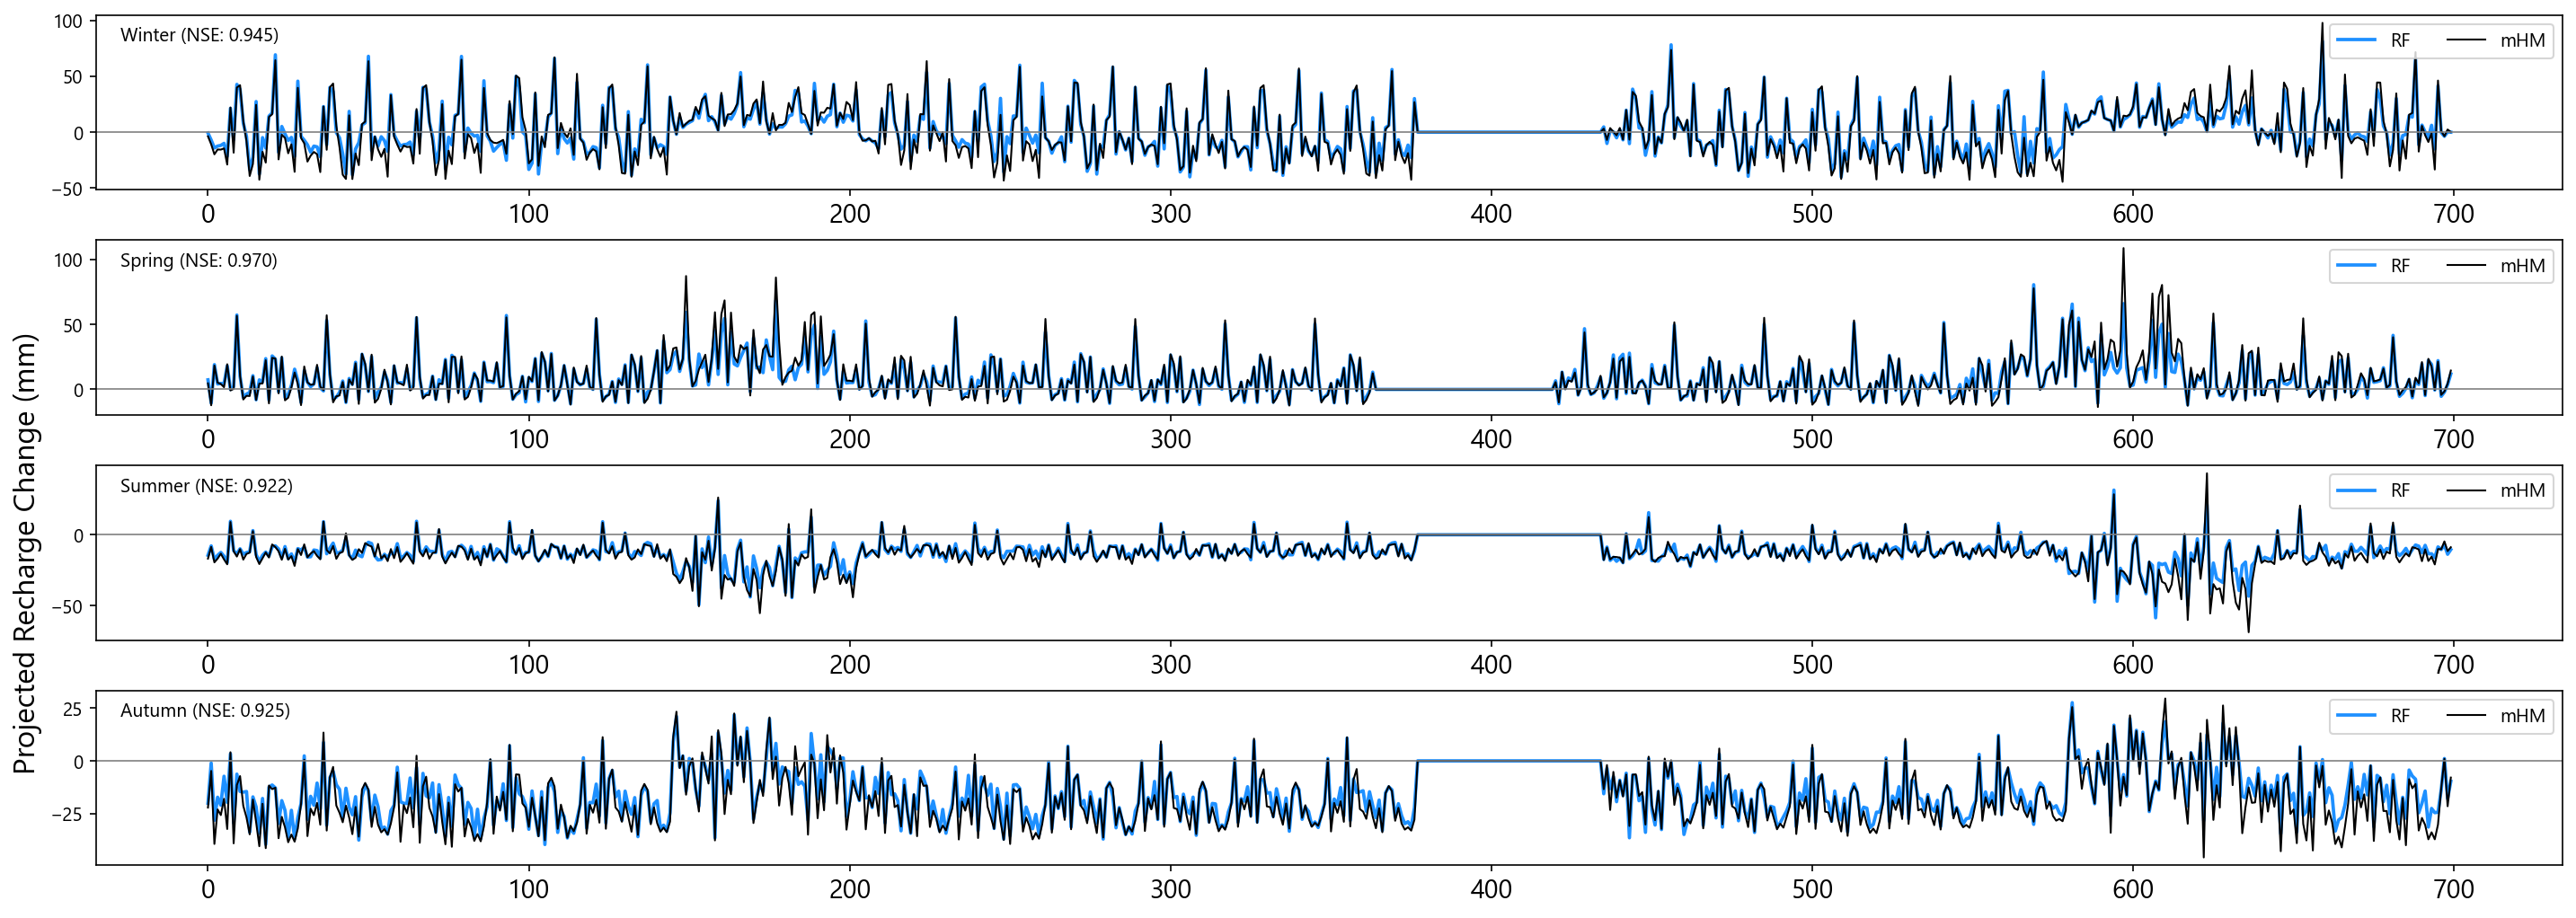

In [532]:
season_order = ['winter', 'spring', 'summer', 'autumn']

fig, ax = plt.subplots(4, 1, figsize=(19, 6.7), dpi=150, constrained_layout=True)

for s_idx, season in enumerate(season_order):
    if season not in seasonal_emulators:
        continue

    results = seasonal_emulators[season]
    y_pred = results['y_pred_test']
    y_test = results['y_test']
    nse    = results['nse']

    ax_s = ax[s_idx]
    ax_s.plot(y_pred[:700], color='dodgerblue', lw=1.8, label='RF')
    ax_s.plot(y_test[:700], color='k', lw=1.0, label='mHM')
    ax_s.axhline(0, color='gray', lw=0.8)
    ax_s.text(0.01, 0.85, f"{season.capitalize()} (NSE: {nse:.3f})",
              transform=ax_s.transAxes, ha='left')
    ax_s.tick_params(axis='x', labelsize=14)

    if s_idx == 2:
        ax_s.set_ylabel('Projected Recharge Change (mm)', fontsize=16)

    ax_s.legend(ncol=2, loc='upper right')

plt.show()


In [533]:

feature_names = ['pet', 'pre', 'wa_lag1']

# How many pixels per season to use for SHAP
N_PIXELS_SHAP = 400      # number of grid cells
N_SHAP_ROWS_MAX = 5000   # optional extra safety cap on rows

shap_vals_dict = {}
seasonal_bucket_importance = {}

rng_global = np.random.default_rng(42)  # global RNG for reproducibility

for season, results in seasonal_emulators.items():
    best_model = results['model']

    # 1) Get the season dataframe used for training
    df_season = df_train[df_train['season'] == season].copy()

    # Make sure required columns exist
    for col in ['pet', 'pre', 'wa_lag1', 'roi']:
        if col not in df_season.columns:
            raise ValueError(f"Column '{col}' missing for season {season}")

    if df_season.empty:
        print(f"No samples for season {season}, skipping.")
        continue

    # 2) Build pixel IDs from (roi, lat, lon)
    df_season['pixel_id'] = (
        df_season['roi'].astype(str)
    )

    unique_pixels = df_season['pixel_id'].unique()
    if len(unique_pixels) == 0:
        print(f"No pixels for season {season}, skipping.")
        continue

    # 3) Sample pixels (not rows)
    n_pix = min(N_PIXELS_SHAP, len(unique_pixels))
    pix_sel = rng_global.choice(unique_pixels, size=n_pix, replace=False)

    df_shap = df_season[df_season['pixel_id'].isin(pix_sel)].copy()

    # Optional extra subsampling by rows if still huge
    if len(df_shap) > N_SHAP_ROWS_MAX:
        idx_rows = rng_global.choice(len(df_shap), size=N_SHAP_ROWS_MAX, replace=False)
        df_shap = df_shap.iloc[idx_rows]

    X = df_shap[feature_names].values

    if X.shape[0] == 0:
        print(f"No SHAP rows for season {season} after sampling, skipping.")
        continue

    # 4) SHAP computation
    explainer = shap.TreeExplainer(best_model)
    shap_values = explainer.shap_values(X, check_additivity=False)
    if isinstance(shap_values, list):
        shap_values = shap_values[0]

    shap_vals_dict[season] = shap_values

    # 5) Aggregate to mean |SHAP| and bucket shares
    mean_abs = np.mean(np.abs(shap_values), axis=0)
    share = mean_abs / (mean_abs.sum() + 1e-12)

    imp = (
        pd.DataFrame({
            'feature': feature_names,
            'mean_abs_shap_mm': mean_abs,
            'share': share
        })
        .sort_values('mean_abs_shap_mm', ascending=False)
    )

    def bucket(name: str) -> str:
        n = name.lower()
        if 'pre'     in n: return 'WATER'   # dP
        if 'pet'     in n: return 'PET'     # dPET
        if 'wa_lag1' in n: return 'Memory'  # d(P−PET)
        return 'Other'

    bucket_imp = (
        imp.assign(bucket=imp['feature'].map(bucket))
           .groupby('bucket', as_index=False)
           .agg(mean_abs_shap_mm=('mean_abs_shap_mm', 'sum'))
           .assign(share=lambda d: d['mean_abs_shap_mm'] / d['mean_abs_shap_mm'].sum())
           .sort_values('mean_abs_shap_mm', ascending=False)
    )

    seasonal_bucket_importance[season] = bucket_imp

    print(f"Summary contribution {season}:")
    print("---------------------------------------")
    print(bucket_imp)
    print(" ")


Summary contribution winter:
---------------------------------------
   bucket  mean_abs_shap_mm     share
2   WATER         12.397270  0.663282
0  Memory          4.497906  0.240648
1     PET          1.795611  0.096069
 
Summary contribution spring:
---------------------------------------
   bucket  mean_abs_shap_mm     share
2   WATER          7.731837  0.715399
0  Memory          1.575382  0.145764
1     PET          1.500504  0.138836
 
Summary contribution summer:
---------------------------------------
   bucket  mean_abs_shap_mm     share
2   WATER          3.611862  0.581867
0  Memory          1.520747  0.244991
1     PET          1.074763  0.173143
 
Summary contribution autumn:
---------------------------------------
   bucket  mean_abs_shap_mm     share
2   WATER          3.959463  0.372686
0  Memory          3.430187  0.322868
1     PET          3.234479  0.304447
 


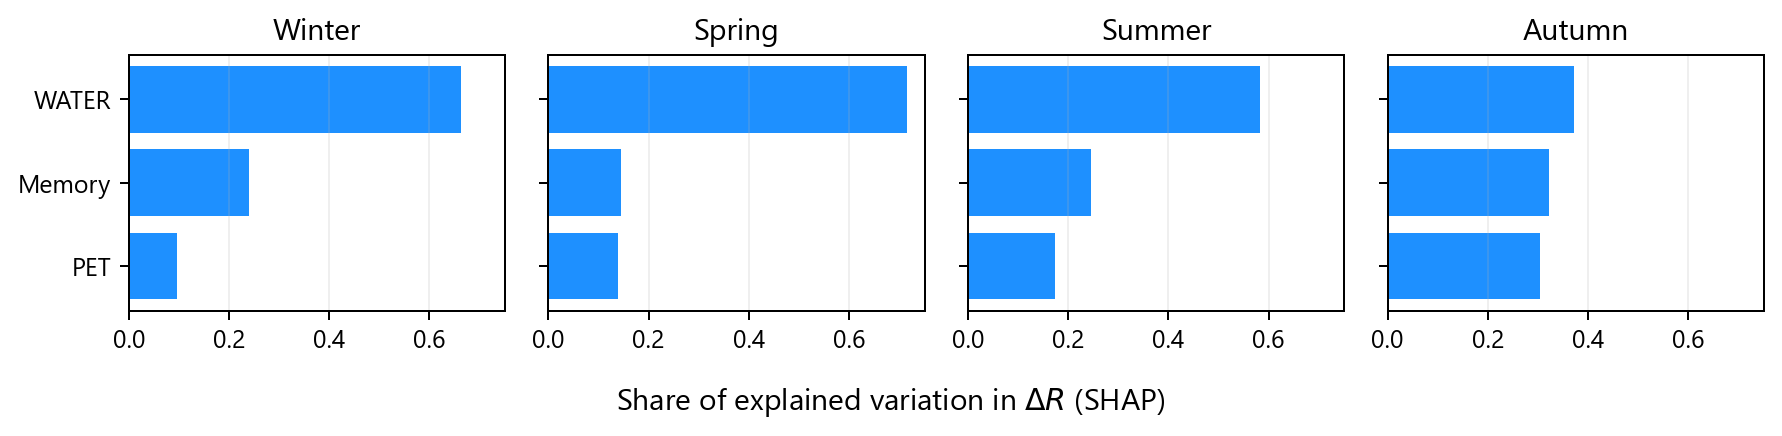

In [534]:

# feature_names = ['dPET', 'dP', 'dWA']
season_order = ['winter', 'spring', 'summer', 'autumn']  # adjust if your keys differ
bucket_order = ['PET', 'Memory', 'WATER']  # top → bottom in all panels


fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), dpi=180, sharex=True)
axes = axes.ravel()

for i, season in enumerate(season_order):
    share_imp = seasonal_bucket_importance[season].copy()

    # set index to bucket and reorder rows to fixed order
    share_imp = (share_imp.set_index('bucket')
                            .loc[bucket_order]        # enforce same order
                            .reset_index())

    ax = axes[i]
    ax.barh(share_imp['bucket'], share_imp['share'],
            height=0.8, color='dodgerblue')
    ax.set_title(season.capitalize())
    ax.grid(alpha=0.2, axis='x')

    if i != 0:
        ax.set_yticklabels([])

fig.supxlabel('Share of explained variation in $\Delta R$ (SHAP)', y=0.05)
plt.tight_layout()
plt.show()